## Estadística Aplicada

Nombre: Barbara Govea Serna

Matrícula: 1902869

Grupo: 042

Actividad para exentar la elaboración del PIA

In [33]:
# Librerias básicas 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
%matplotlib inline

In [34]:
# Librerias especializadas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [35]:
# Formato de gráficas
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize']=12

## 1. Descargar la base de datos con base en el video adjunto, se debe elegir un periodo y en la notebook se debe justificar el periodo elegido

In [36]:
IMCP_base=pd.read_csv('Indicadores2023-10años.csv') 

In [37]:
IMCP_base

,Periodos,IMCM
0,2013/07,91.199834
1,2013/08,91.109014
2,2013/09,90.607990
3,2013/10,90.996438
4,2013/11,90.950552
...,...,...
116,2023/03,106.762443
117,2023/04,107.928291
118,2023/05,107.775653
119,2023/06,108.168118


Para estimar el Indicador Mensual del Consumo Privado tomamos datos historicos de 10 años, un periodo lo suficientemente amplio para observar y comprender las tendencias, además son los datos mas recientes para lograr estimación precisa. De INEGI, tomamos los datos desestacionalizado para analizar tendencias que puedan estar relacionadas con el crecimiento económico a largo plazo, las tendencias demograficas o las preferencias del consumidor, con eso también eliminamos efectos estacionales que no son recomendados para realizar estimaciones

## 2. Verificar tipo de variables y no existencia de missing values

In [38]:
IMCP_base.dtypes

Periodos     object
IMCM        float64
dtype: object

In [39]:
IMCP_base.isna().sum()

Periodos    0
IMCM        0
dtype: int64

In [40]:
# Formato fecha
IMCP_base['Periodos']=pd.to_datetime(IMCP_base['Periodos'],format='%Y/%m')
IMCP_base.head(1)

,Periodos,IMCM
0,2013-07-01,91.199834


In [41]:
# Fecha index
IMCP_base=IMCP_base.set_index('Periodos') 
IMCP_base.head(1)


,IMCM
Periodos,
2013-07-01,91.199834


In [42]:
# Asignar una frecuencia
IMCP_base=IMCP_base.asfreq('MS')

## 3. Gráfico de la serie (títulos, nombre a ejes etc)

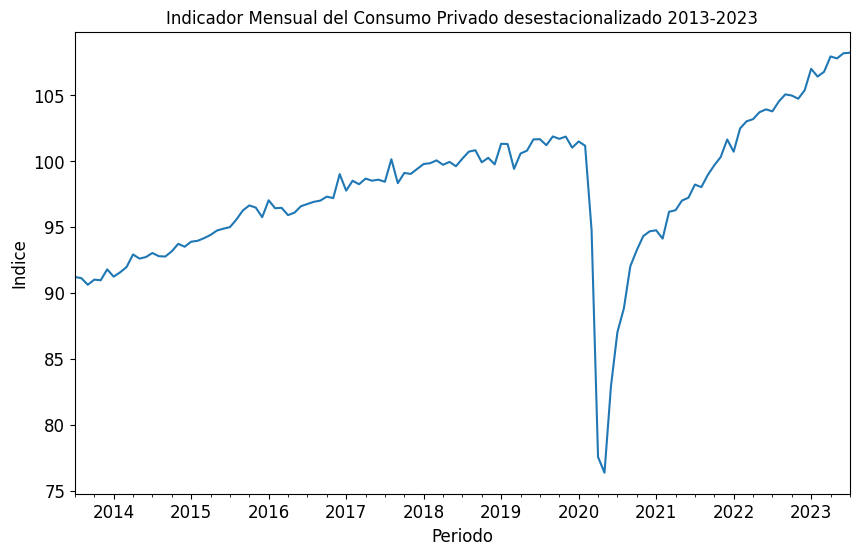

In [43]:
IMCP_base['IMCM'].plot()
plt.title('Indicador Mensual del Consumo Privado desestacionalizado 2013-2023')
plt.ylabel('Indice')
plt.xlabel('Periodo')
plt.show()

## 4. Realiza un pronóstico del índice:

### a) Realiza una prueba de raíz unitaria a la serie original

PRUEBA DE DICKEY FULLER AUMENTADA

In [44]:
prueba_DFA=adfuller(IMCP_base['IMCM'])
pvalue=prueba_DFA[1]
print(pvalue.round(2))
if pvalue <= 0.05: 
    print("Rechazamos la hipotesis nula, la serie es estacionaria")
else:
    print("No rechazamos la hipótesis nula, la serie no es estacionaria")

0.27
No rechazamos la hipótesis nula, la serie no es estacionaria


Debemos volverla estacionaria para poder proceder a estimar

### b) En caso de que no sea estacionaria aplica primeras diferencias, y realiza la prueba de raíz unitaria para verificar que la serie sea estacionaria

In [45]:
# Primeras diferencias 
IMCP_base['IMCM_DIFF'] = IMCP_base['IMCM'].diff()
IMCP_base.head()

,IMCM,IMCM_DIFF
Periodos,,
2013-07-01,91.199834,NaN
2013-08-01,91.109014,-0.090821
2013-09-01,90.607990,-0.501024
2013-10-01,90.996438,0.388448
2013-11-01,90.950552,-0.045886


Realizamos la PRUEBA DE DICKEY FULLER AUMENTADA para las primeras diferencias

In [46]:
prueba_DFA1=adfuller(IMCP_base['IMCM_DIFF'].dropna())
pvalue1= prueba_DFA1[1]
print(pvalue1.round(2))
if pvalue1 <= 0.05: 
    print("Rechazamos la hipotesis nula, la serie es estacionaria")
else:
    print("No rechazamos la hipótesis nula, la serie no es estacionaria")

0.0
Rechazamos la hipotesis nula, la serie es estacionaria


### c) Si la serie no es estacionaria repite el paso b hasta que la serie sea estacionaria

La serie de las primeras diferencias si es estacionaria

### d) Realiza las graficas de autocorrelación de la serie estacionaria para verificar si la serie tiene o no un componente estacional


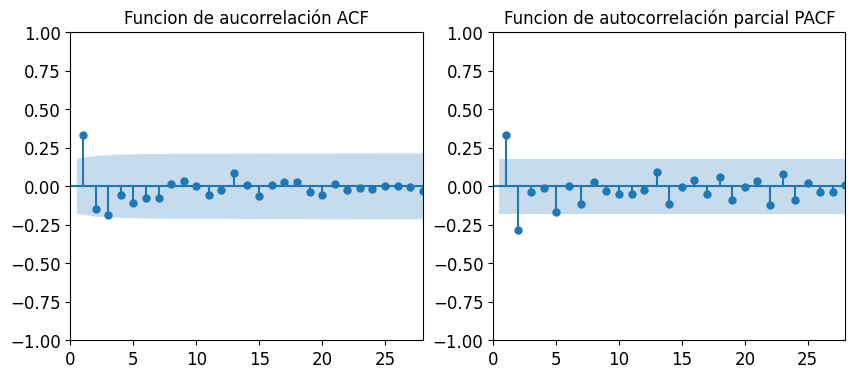

In [47]:
ig, ax = plt.subplots(1,2,figsize=(10,4))
# Primer subgrafica
plot_acf(IMCP_base['IMCM_DIFF'].dropna(),zero=False,lags=28,ax=ax[0],title='Funcion de aucorrelación ACF')
ax[0].set_ylim(-1,1)
ax[0].set_xlim(0,28)
# Segunda subgrafica
plot_pacf(IMCP_base['IMCM_DIFF'].dropna(),zero=False,lags=28,ax=ax[1],title='Funcion de autocorrelación parcial PACF')
ax[1].set_ylim(-1,1)
ax[1].set_xlim(0,28)
plt.show()

En la primera grafica, estamos mirando cuánto se parecen o estan relacionados los valores de la serie en diferentes momentos en el tiempo. En el pico alto en esta grafica, nos da a entender que hay una correlación entre los valores en esos momentos.

La segunda grafica se enfoca en mirar la correlación que no se explica por los momentos intermedios. 

Ambas nos permiten entender como los valores de la serie  estan relacionados en el tiempo, al tener un pico alto entre el 0, podría decirse 1, se debe a que los datos son diarios, lo confirmamos en la serie

### e) Utiliza auto_arima para encontrar el orden del modelo arima, dando el parámetro information_criterion, prueba y muestra el resultado, con aic, bic, hqic, oob.

In [48]:
# Utilizano criterio AIC
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='aic',
              seasonal=False)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [49]:
# Utilizano criterio BIC
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='bic',
              seasonal=False)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [50]:
# Utilizano criterio HQIC
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='hqic',
              seasonal=False)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [51]:
# Utilizano criterio OOB
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='oob',
              seasonal=False)

c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [52]:
criterios = ['aic', 'bic', 'hqic', 'oob']

for criterio in criterios:
    model = auto_arima(IMCP_base['IMCM_DIFF'].dropna(), information_criterion=criterio)
    print(f"Mejor modelo ARIMA con {criterio}: {model.summary()}")

Mejor modelo ARIMA con aic:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -241.955
Date:                Thu, 02 Nov 2023   AIC                            487.910
Time:                        23:05:50   BIC                            493.485
Sample:                    08-01-2013   HQIC                           490.174
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4195      0.041     10.328      0.000       0.340       0.499
sigma2         3.2972      0.138     23.840      0.000       3.026       3.568
Ljung-Box (L1) (Q):     

c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


Mejor modelo ARIMA con oob:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -241.955
Date:                Thu, 02 Nov 2023   AIC                            487.910
Time:                        23:05:54   BIC                            493.485
Sample:                    08-01-2013   HQIC                           490.174
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4195      0.041     10.328      0.000       0.340       0.499
sigma2         3.2972      0.138     23.840      0.000       3.026       3.568
Ljung-Box (L1) (Q):     

### f) Utilizar el método del if con AR y MA para ver que modelos sugieren el BIC y el AIC

Suponer IMCM_DIFF es una AR(1) = ARMA(1,0) = ARIMA (1,0,0)

Estimaremos ARIMA (MCO)

In [53]:
modelo_prueba=ARIMA(IMCP_base['IMCM_DIFF'],order=(1,0,0))
resultado=modelo_prueba.fit()
print(resultado.summary())

                               SARIMAX Results                                
Dep. Variable:              IMCM_DIFF   No. Observations:                  121
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -244.758
Date:                Thu, 02 Nov 2023   AIC                            495.517
Time:                        23:06:02   BIC                            503.904
Sample:                    07-01-2013   HQIC                           498.923
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1404      0.398      0.353      0.724      -0.639       0.920
ar.L1          0.3272      0.044      7.380      0.000       0.240       0.414
sigma2         3.4573      0.153     22.658      0.0

Suponer IMCM_DIFF es una AR(2) = ARMA(2,0) = ARIMA (2,0,0)

In [54]:
modelo_prueba=ARIMA(IMCP_base['IMCM_DIFF'],order=(2,0,0))
resultado2=modelo_prueba.fit()
print(resultado2.summary())

                               SARIMAX Results                                
Dep. Variable:              IMCM_DIFF   No. Observations:                  121
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -239.705
Date:                Thu, 02 Nov 2023   AIC                            487.410
Time:                        23:06:05   BIC                            498.593
Sample:                    07-01-2013   HQIC                           491.952
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1422      0.315      0.451      0.652      -0.475       0.760
ar.L1          0.4209      0.051      8.238      0.000       0.321       0.521
ar.L2         -0.2819      0.080     -3.535      0.0

In [55]:
# Debemos elegir el menor AIC
ic={}
for ar in range(7):
    for ma in range(7):
        print(f"AR:{ar}, MA={ma}")
        modelo = ARIMA(IMCP_base['IMCM_DIFF'],order=[ar,1,ma])
        resultado = modelo.fit()
        ic[(ar,ma)] = [resultado.aic,resultado.bic] 
ic = pd.DataFrame(ic,index=['AIC','BIC']).T
ic.index = ic.index.set_names(['AR','MA'])       

ic.sort_values('AIC').head(1)

AR:0, MA=0
AR:0, MA=1
AR:0, MA=2
AR:0, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:0, MA=4
AR:0, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:0, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:1, MA=0
AR:1, MA=1
AR:1, MA=2


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:1, MA=3
AR:1, MA=4
AR:1, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:1, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:2, MA=0
AR:2, MA=1
AR:2, MA=2
AR:2, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:2, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:2, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:2, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:3, MA=0
AR:3, MA=1
AR:3, MA=2


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:3, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:3, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:3, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:3, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:4, MA=0
AR:4, MA=1
AR:4, MA=2


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:4, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:4, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:4, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:4, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:5, MA=0
AR:5, MA=1
AR:5, MA=2


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:5, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:5, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:5, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:5, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:6, MA=0
AR:6, MA=1
AR:6, MA=2
AR:6, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parame

AR:6, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:6, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:6, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,,AIC,BIC
AR,MA,,
2,6,503.527342,528.614768


### g) Con los dos incisos anteriores elegir el orden ARIMA a estimar

Las primeras diferencias del IMCM son un ARMA(2,6) = ARIMA (2,1,6)

### h) Estimar el modelo

In [56]:
model = ARIMA(IMCP_base['IMCM'], order=(2,1,6))
results=model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   IMCM   No. Observations:                  121
Model:                 ARIMA(2, 1, 6)   Log Likelihood                -237.084
Date:                Thu, 02 Nov 2023   AIC                            492.168
Time:                        23:06:51   BIC                            517.255
Sample:                    07-01-2013   HQIC                           502.356
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4716      0.968      0.487      0.626      -1.426       2.369
ar.L2          0.4068      0.738      0.551      0.581      -1.039       1.853
ma.L1         -0.0452      0.983     -0.046      0.9

### i) Pronosticar tres periodos

In [57]:
results.predict('2023-08-01','2023-10-01')

2023-08-01    107.544467
2023-09-01    106.950058
2023-10-01    106.740579
Freq: MS, Name: predicted_mean, dtype: float64

### j) Mostrar en un print el pronóstico para agosto de 2023 con sus intervalos de confianza al 95%

In [59]:
# Obtener el intervalo de confianza de los pronosticos 
forecast = results.get_forecast(steps=6)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [60]:
inicio= '2023-08-01'
final= '2023-10-01'
pronostico_valor = forecast_mean[inicio:final]
pronostico_intervalos = forecast_ci.loc[inicio:final]

In [61]:
df_pronostico = pd.DataFrame({'Pronostico': pronostico_valor,
                              'Limite inferior': pronostico_intervalos.iloc[:,0],
                              'Limite superior': pronostico_intervalos.iloc[:,1]
                              })
df_pronostico

,Pronostico,Limite inferior,Limite superior
2023-08-01,107.544467,104.136186,110.952748
2023-09-01,106.950058,101.012846,112.887270
2023-10-01,106.740579,99.342626,114.138532


In [68]:
pronost = df_pronostico.iloc[0,0].round(2)
lim_inf = df_pronostico.iloc[0,1].round(2)
lim_sup = df_pronostico.iloc[0,2].round(2)

In [69]:

print(f'El valor estimado del Indicador Mensual del Consumo Privado para agosto 2023 es: {pronost} y se encuentra en un intervalo de confianza de ({lim_inf}-{lim_sup})')

El valor estimado del Indicador Mensual del Consumo Privado para agosto 2023 es: 107.54 y se encuentra en un intervalo de confianza de (104.14-110.95)
